In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.filterwarnings('ignore')

from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score, precision_recall_curve

In [38]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dnkumars/cybersecurity-intrusion-detection-dataset")

print("Path to dataset files:", path)
print(os.listdir(path))

Using Colab cache for faster access to the 'cybersecurity-intrusion-detection-dataset' dataset.
Path to dataset files: /kaggle/input/cybersecurity-intrusion-detection-dataset
['cybersecurity_intrusion_data.csv']


In [39]:
df = pd.read_csv(path + '/cybersecurity_intrusion_data.csv')
df.head()

,session_id,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access,attack_detected
0,SID_00001,599,TCP,4,492.983263,DES,0.606818,1,Edge,0,1
1,SID_00002,472,TCP,3,1557.996461,DES,0.301569,0,Firefox,0,0
2,SID_00003,629,TCP,3,75.044262,DES,0.739164,2,Chrome,0,1
3,SID_00004,804,UDP,4,601.248835,DES,0.123267,0,Unknown,0,1
4,SID_00005,453,TCP,5,532.540888,AES,0.054874,1,Firefox,0,0


In [40]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9537 entries, 0 to 9536
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   session_id           9537 non-null   object 
 1   network_packet_size  9537 non-null   int64  
 2   protocol_type        9537 non-null   object 
 3   login_attempts       9537 non-null   int64  
 4   session_duration     9537 non-null   float64
 5   encryption_used      7571 non-null   object 
 6   ip_reputation_score  9537 non-null   float64
 7   failed_logins        9537 non-null   int64  
 8   browser_type         9537 non-null   object 
 9   unusual_time_access  9537 non-null   int64  
 10  attack_detected      9537 non-null   int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 819.7+ KB


,0
session_id,0
network_packet_size,0
protocol_type,0
login_attempts,0
session_duration,0
encryption_used,1966
ip_reputation_score,0
failed_logins,0
browser_type,0
unusual_time_access,0


Handle nan data encryption_used

In [41]:
for col in ['protocol_type', 'browser_type', 'encryption_used']:
    print(col, df[col].unique())

protocol_type ['TCP' 'UDP' 'ICMP']
browser_type ['Edge' 'Firefox' 'Chrome' 'Unknown' 'Safari']
encryption_used ['DES' 'AES' nan]


In [43]:
df['encryption_used'] = df['encryption_used'].fillna('Unknown')

In [44]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9537 entries, 0 to 9536
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   session_id           9537 non-null   object 
 1   network_packet_size  9537 non-null   int64  
 2   protocol_type        9537 non-null   object 
 3   login_attempts       9537 non-null   int64  
 4   session_duration     9537 non-null   float64
 5   encryption_used      9537 non-null   object 
 6   ip_reputation_score  9537 non-null   float64
 7   failed_logins        9537 non-null   int64  
 8   browser_type         9537 non-null   object 
 9   unusual_time_access  9537 non-null   int64  
 10  attack_detected      9537 non-null   int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 819.7+ KB


,0
session_id,0
network_packet_size,0
protocol_type,0
login_attempts,0
session_duration,0
encryption_used,0
ip_reputation_score,0
failed_logins,0
browser_type,0
unusual_time_access,0


EDA

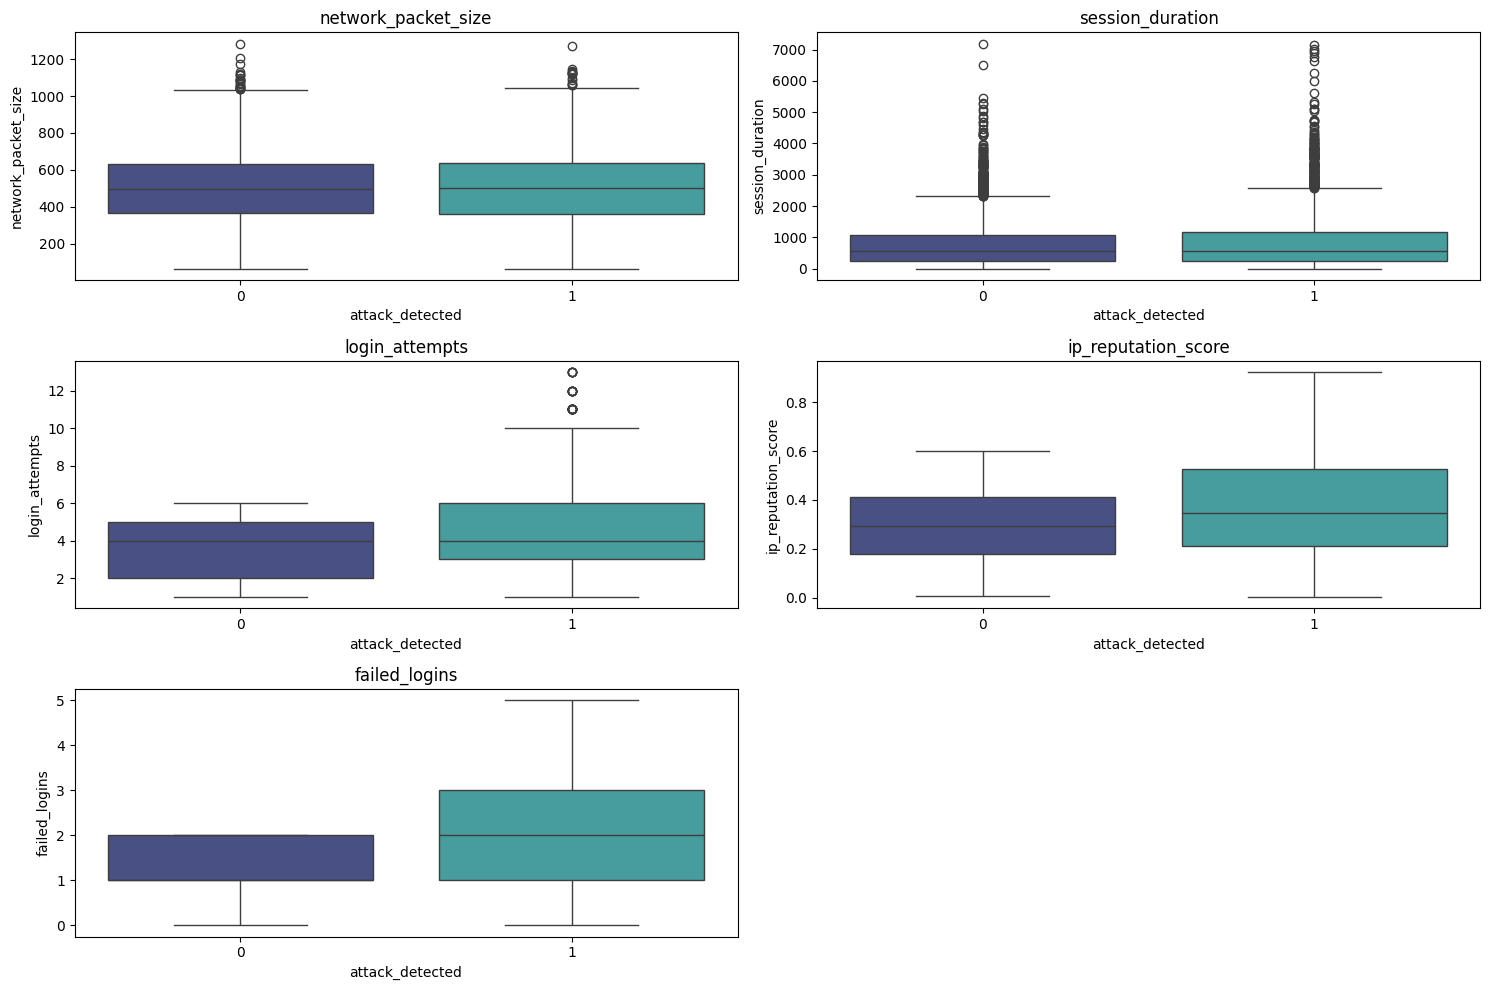

In [65]:
num_cols = [
    'network_packet_size',
    'session_duration',
    'login_attempts',
    'ip_reputation_score',
    'failed_logins'
]

plt.figure(figsize=(15,10))
for i, col in enumerate(num_cols):
    plt.subplot(3,2,i+1)
    sns.boxplot(x=df['attack_detected'],
                y=df[col],
                palette="mako",
                )
    plt.title(col)

plt.tight_layout()
plt.show()

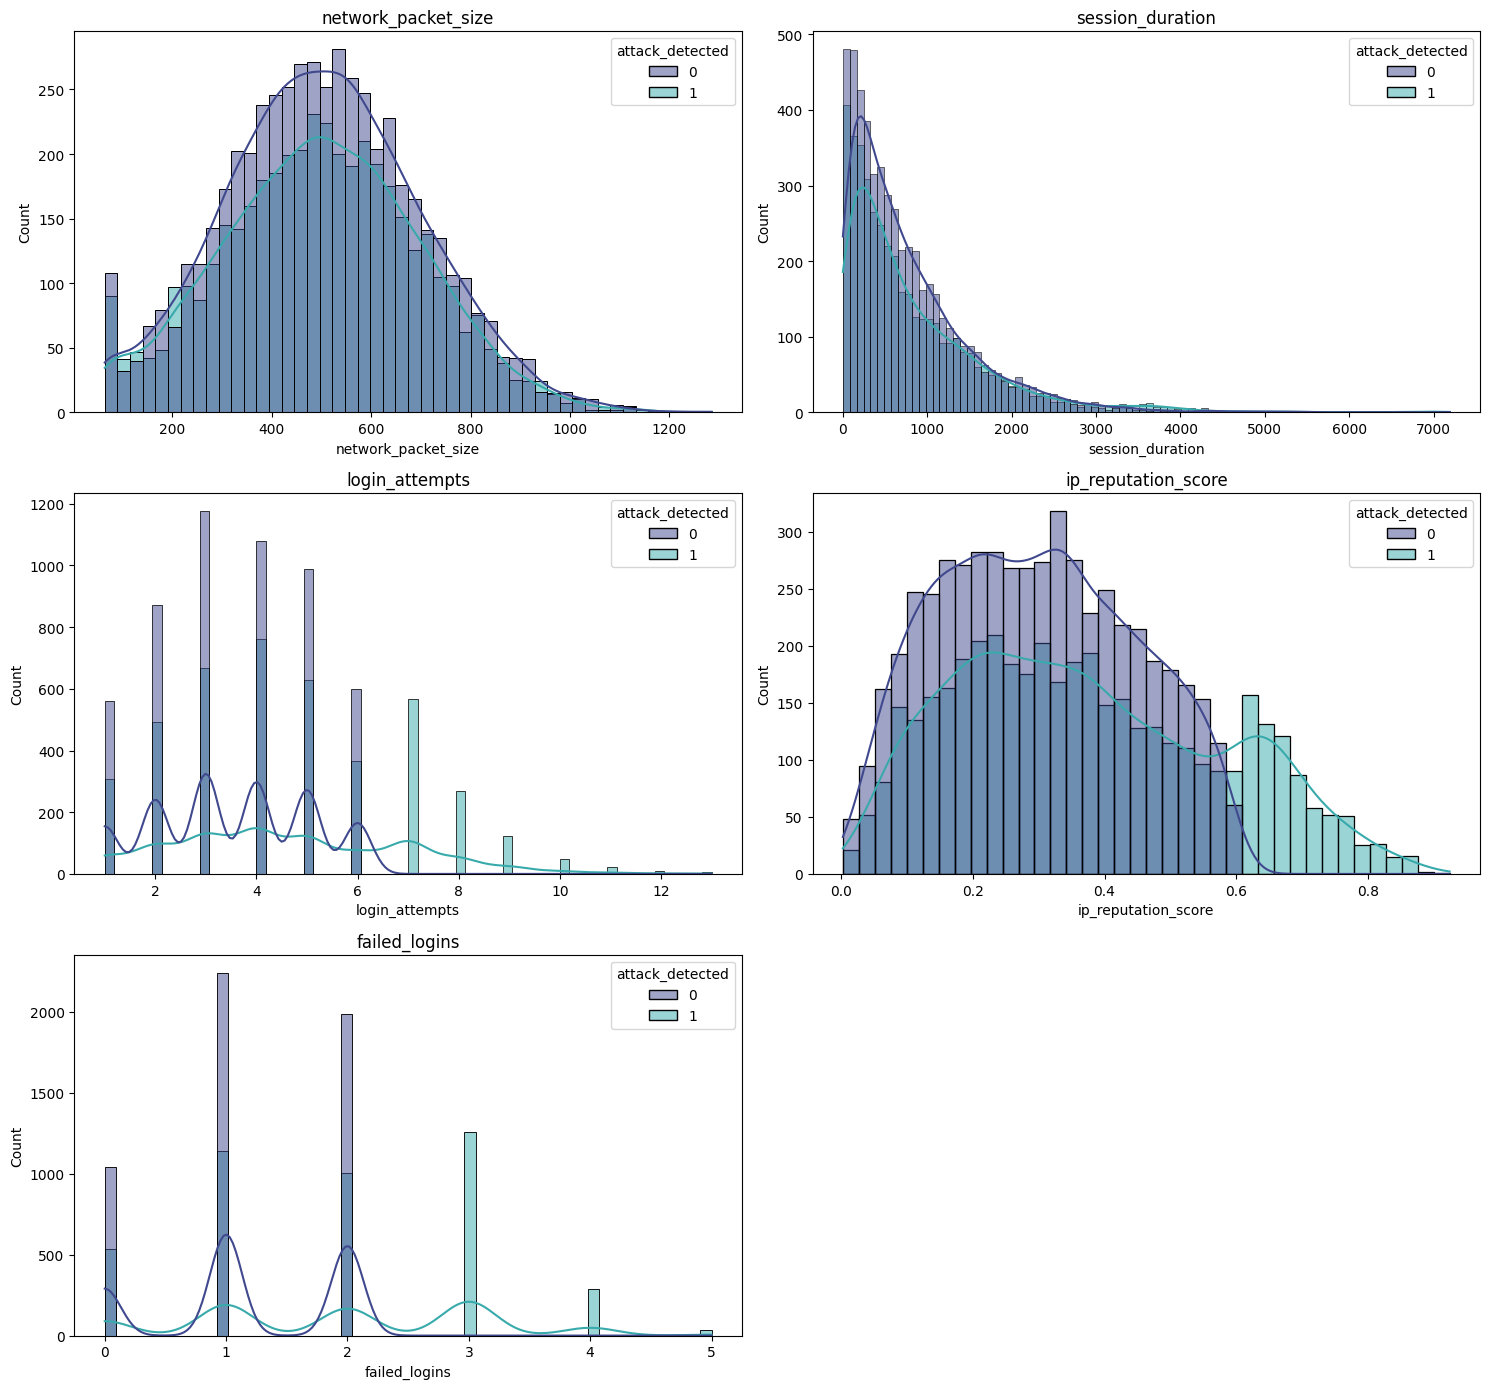

In [67]:
num_cols = [
    'network_packet_size',
    'session_duration',
    'login_attempts',
    'ip_reputation_score',
    'failed_logins'
]

plt.figure(figsize=(15,14))
for i, col in enumerate(num_cols):
  plt.subplot(3,2,i+1)
  sns.histplot(
      x=df[col],
      hue=df['attack_detected'],
      kde=True,
      palette="mako"
  )
  plt.title(col)

plt.tight_layout()
plt.show()

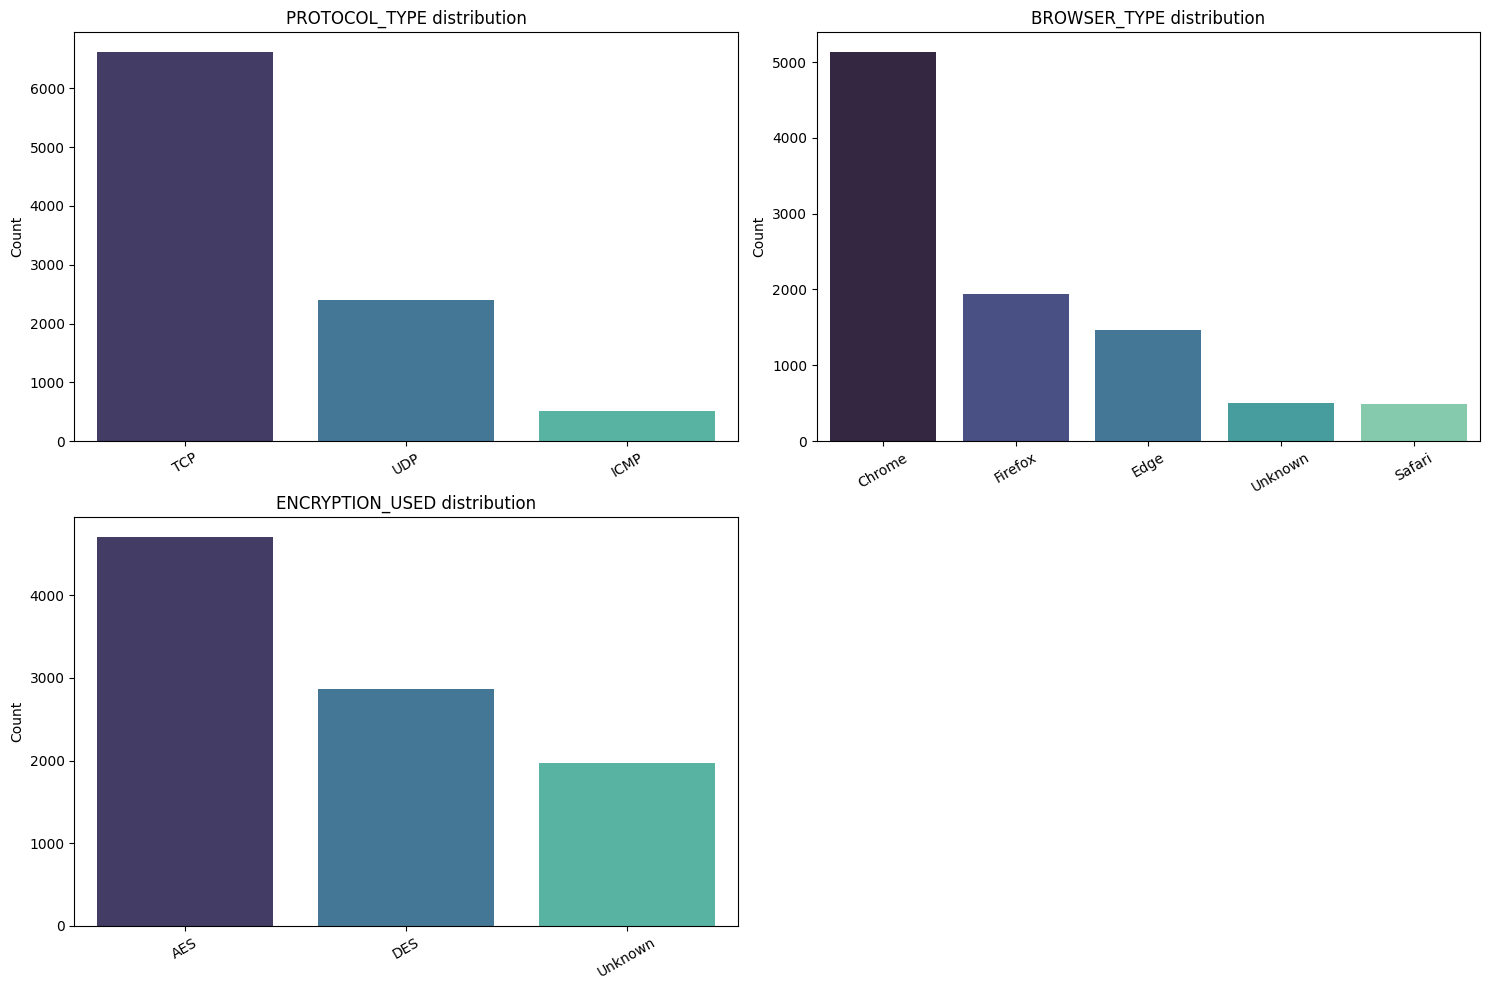

In [66]:
cat_cols = ['protocol_type', 'browser_type', 'encryption_used']

plt.figure(figsize=(15,10))
for i, col in enumerate(cat_cols):
    plt.subplot(2,2,i+1)
    sns.countplot(
        x=df[col],
        order=df[col].value_counts().index,
        palette="mako"
    )
    plt.title(f"{col.upper()} distribution")
    plt.xticks(rotation=30)
    plt.ylabel("Count")
    plt.xlabel("")

plt.tight_layout()
plt.show()

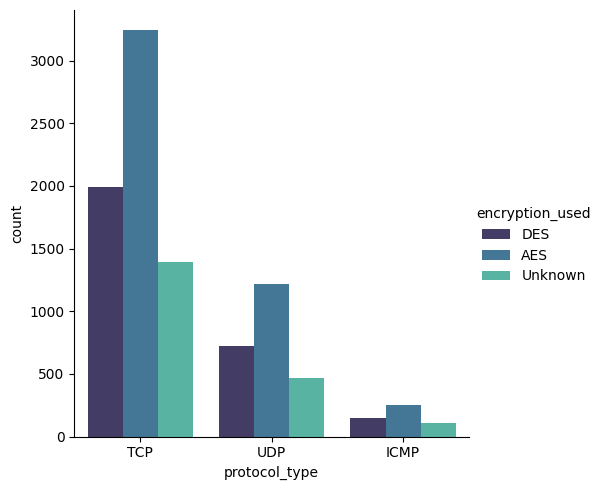

In [116]:
sns.catplot(x=df['protocol_type'],
            hue=df['encryption_used'],
            kind='count',
            palette="mako")
plt.show()

Split Data

In [72]:
X = df.drop(['attack_detected', 'session_id'], axis=1)
y = df['attack_detected']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [73]:
numerical_features = [
    'network_packet_size',
    'login_attempts',
    'session_duration',
    'ip_reputation_score',
    'failed_logins',
    'unusual_time_access'
]

categorical_features = [
    'protocol_type',
    'browser_type',
    'encryption_used'
]

In [74]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

svm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', SVC(kernel='rbf',
                  C=1,
                  random_state=42))
])

In [75]:
svm_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['network_packet_size',
                                                   'login_attempts',
                                                   'session_duration',
                                                   'ip_reputation_score',
                                                   'failed_logins',
                                                   'unusual_time_access']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['protocol_type',
                                                   'browser_type',
                                                   'encryption_used'])])),
                ('model', SVC(C=1, random_state=42))])

In [77]:
y_pred = svm_pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1_score = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("F1 Score:", f1_score)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.8726415094339622
F1 Score: 0.8389662027833003
Precision: 0.9649390243902439
Recall: 0.7420867526377491


In [79]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.98      0.89      1055
           1       0.96      0.74      0.84       853

    accuracy                           0.87      1908
   macro avg       0.89      0.86      0.87      1908
weighted avg       0.89      0.87      0.87      1908



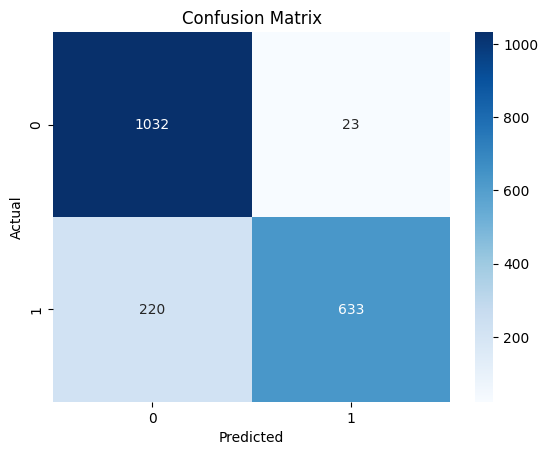

In [80]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

ROC AUC

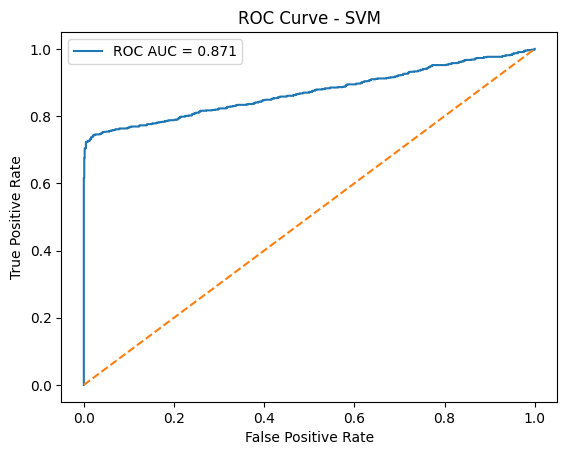

In [88]:
svm_pipeline.named_steps['model'].probability = True
svm_pipeline.fit(X_train, y_train)

y_score = svm_pipeline.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.3f}')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM')
plt.legend()
plt.show()

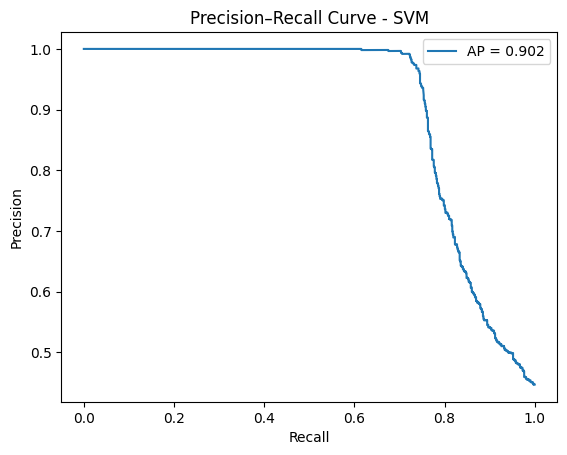

In [89]:
precision, recall, _ = precision_recall_curve(y_test, y_score)
ap_score = average_precision_score(y_test, y_score)

plt.figure()
plt.plot(recall, precision, label=f'AP = {ap_score:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve - SVM')
plt.legend()
plt.show()

Feature Importance per Mutation

In [99]:
result = permutation_importance(
    svm_pipeline,
    X_test,
    y_test,
    n_repeats=10,
    random_state=42,
    scoring='f1'
)

preprocessor = svm_pipeline.named_steps['preprocessor']

num_features = numerical_features

cat_features = (
    preprocessor
    .named_transformers_['cat']
    .get_feature_names_out(categorical_features)
)

feature_names = np.concatenate([num_features, cat_features])

In [100]:
print(len(feature_names))
print(len(result.importances_mean))

17
9


In [111]:
importance_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance': result.importances_mean
}).sort_values(by='importance', ascending=False)

importance_df.head()

,feature,importance
6,failed_logins,0.226677
2,login_attempts,0.152183
5,ip_reputation_score,0.112023
7,browser_type,0.037475
8,unusual_time_access,0.007869
